In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [72]:
#read in data
df = pd.read_csv('data/hourly_nm.csv',index_col='Date/Time')
df.head()

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-01-01 01:00:00,460.537125,5.644205,513.418408,52.881284,-1.068567,-5.515860,390.480362
2018-01-01 02:00:00,733.655375,6.452037,788.401310,54.745935,-0.176225,-6.440522,460.537125
2018-01-01 03:00:00,909.362081,6.811455,948.793346,39.431265,-1.652917,-6.596464,733.655375
2018-01-01 04:00:00,1393.518188,7.748749,1406.391795,12.873607,-2.912491,-7.138868,909.362081
2018-01-01 05:00:00,1149.599162,7.236854,1128.194441,-21.404721,-3.170687,-6.478943,1393.518188


In [73]:
print(df.info())
print()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 8759 entries, 2018-01-01 01:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Power              8759 non-null   float64
 1   Wind_speed         8759 non-null   float64
 2   Theoretical_power  8759 non-null   float64
 3   Loss               8759 non-null   float64
 4   x_com              8759 non-null   float64
 5   y_com              8759 non-null   float64
 6   T_1                8759 non-null   float64
dtypes: float64(7)
memory usage: 547.4+ KB
None

             Power   Wind_speed  Theoretical_power         Loss        x_com  \
count  8759.000000  8759.000000        8759.000000  8759.000000  8759.000000   
mean   1318.141216     7.463044        1477.300912   159.159695     0.425291   
std    1272.154339     4.161819        1334.998877   316.032952     6.453773   
min      -0.179522     0.000000           0.000000  -342.198605  

In [74]:
#split data into training and testing, testing data will be one month
start_test = '2018-11-31'

train, test = df.loc[:start_test], df.loc[start_test:]

In [75]:
train.tail(1)

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-11-30 23:00:00,87.315742,5.643659,516.885226,429.569483,3.995407,3.978305,231.796605


In [76]:
test.head(1)

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com,T_1
Date/Time,,,,,,,
2018-12-01 00:00:00,280.210704,4.57214,281.809039,1.598335,-2.893603,-3.518642,87.315742


In [77]:
print(len(train))
print(len(test))

8015
744


In [78]:
# scale the data using MinMax Scaler from -1 to 1 as LSTM has a default tanh activation function
SCALER = MinMaxScaler(feature_range=(-1,1))

scaler = SCALER.fit(train.to_numpy())

train_scaled = scaler.transform(train.to_numpy())
test_scaled = scaler.transform(test.to_numpy())

In [79]:
# create a function to split the datasets into two week windows
timestep = 24*7*2 # 24hours,7days,2weeks

def create_dataset(dataset, timestep=timestep):
    """
    Function which creates two week chunks of x_train data, and a single
    value for y_train.
    """
    X, y = [], []
    for i in range(len(dataset)):
        target_value = i + timestep
        if target_value == len(dataset):
            break
        feature_chunk, target = dataset[i:target_value, 1:], dataset[target_value, 0]
        X.append(feature_chunk)
        y.append(target)

    return np.array(X), np.array(y)

In [80]:
#create x_train, y_train, X_test,y_test
X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(test_scaled)

In [81]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7679, 336, 6)
(7679,)
(408, 336, 6)
(408,)


In [82]:
# use sample of th data to train network to have a rough understanding of hyperparameters
samp_len = int(len(X_train)*0.5)

X_sample_train, y_sample_train = X_train[:samp_len], y_train[:samp_len]

In [83]:
print(X_sample_train.shape)
print(y_sample_train.shape)

(3839, 336, 6)
(3839,)


In [84]:
# create X_train, y_train, X_test, y_test datasets
# create a function to build a stacked LSTM model
# input needs to be [samples, timesteps, features]
def create_model(X_train, y_train):
    units = 32
    dropout = 0.05
    epochs = 35
    batch_size = 14
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)
    early_stopping = EarlyStopping(patience=7, monitor='loss')

    model = keras.Sequential()

    #model.add(LSTM(units=units, dropout=dropout, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(LSTM(units=units, dropout=dropout))

    # let's try a simple MLP instead LSTM:
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=32, activation='relu'))

    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    history = model.fit(X_train, y_train, validation_split=0.3, shuffle=False,
              epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    return model, history

In [85]:
# function to predict a single value
def single_prediction(model, history, timestep=timestep):

        history = np.array(history)
        history = history.reshape(history.shape[0]*history.shape[1], history.shape[2])

        input_value = history[-timestep:]
        input_value = input_value.reshape(1, input_value.shape[0], input_value.shape[1])

        yhat = model.predict(input_value, verbose=0)
        return yhat

In [86]:
# function which takes first test chunk, makes a prediction, add the test chunk back into training data
#to make next prediction

def walk_forward_prediction(X_train, y_train, X_test, timestep):

    MODEL, history = create_model(X_train=X_train, y_train=y_train)
    hist_train = [i for i in X_train]
    predictions = []

    for i in range(len(X_test)):
        test = X_test[i]
        yhat = single_prediction(model=MODEL, history=hist_train, timestep=timestep)
        predictions.append(yhat)
        hist_train.append(test)

    return predictions, history, MODEL

In [87]:
def prior_inverse(features, targets):
    '''
    Append prediction value to test dataset and return a test shape format.
    '''
    dataset = []

    for i in range(features.shape[0]):
        last_row, target = features[i][0], targets[i]
        appended = np.append(last_row, target)
        dataset.append(appended)

    return np.array(dataset)

In [88]:
#run experiemnt returning the real, predicted values
def experiment(X_train, y_train, X_test, timestep):

    pred_seq, history, MODEL = walk_forward_prediction(X_train, y_train, X_test, timestep)

    pred_seq = np.array(pred_seq).reshape(-1)

    pred = prior_inverse(X_test, pred_seq)
    real = prior_inverse(X_test, y_test)

    inv_pred = scaler.inverse_transform(pred)
    inv_real = scaler.inverse_transform(real)

    power_pred = inv_pred[:,-1]
    power_real = inv_real[:,-1]

    return power_real, power_pred, history, MODEL

In [89]:
power_real, power_pred, history, MODEL = experiment(X_train, y_train, X_test, timestep)

loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/35
384/384 [==============================] - 28s 70ms/step - loss: 0.5062 - val_loss: 0.5256
Epoch 2/35
384/384 [==============================] - 26s 69ms/step - loss: 0.4943 - val_loss: 0.5280
Epoch 3/35
384/384 [==============================] - 27s 69ms/step - loss: 0.4934 - val_loss: 0.5289
Epoch 4/35
384/384 [==============================] - 27s 70ms/step - loss: 0.4926 - val_loss: 0.5292
Epoch 5/35
384/384 [==============================] - 27s 70ms/step - loss: 0.4920 - val_loss: 0.5286
Epoch 6/35
384/384 [==============================] - 28s 72ms/step - loss: 0.4915 - val_loss: 0.5288
Epoch 7/35
384/384 [==============================] - 28s 72ms/step - loss: 0.4911 - val_loss: 0.5288
Epoch 8/35
384/384 [==============================] - 27s 70ms/step - loss: 0.4909 - val_loss: 0.5289
Epoch 9/35
384/384 [==============================] - 27s 71ms/step - loss: 0.4906 - val_loss: 0.5288
Epoch 10/35
384/384 [==============================] - 26s 68ms/step - loss: 0.490

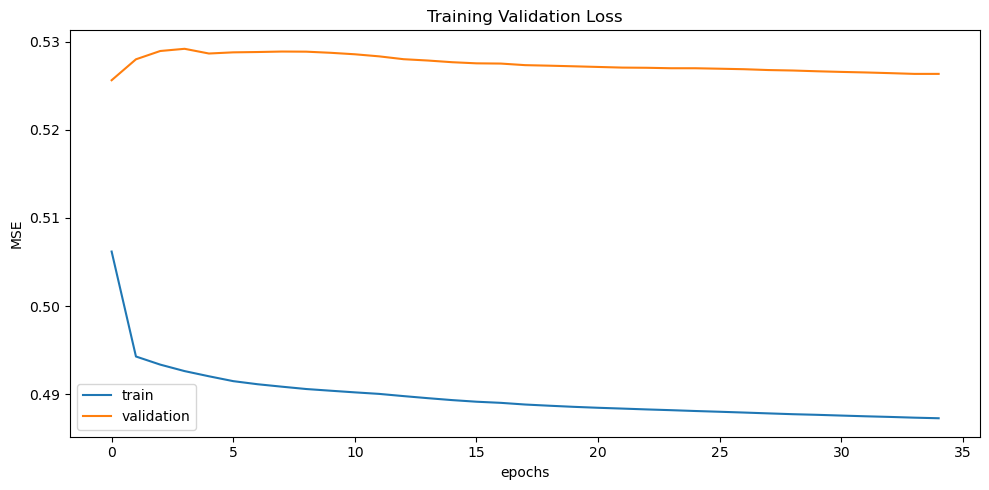

In [90]:
#plot validation and training convergence graph
plt.figure(figsize=(10,5))
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Training Validation Loss')
plt.tight_layout()
plt.savefig('figures/MLP_train_val_plot.png')
plt.show()

In [91]:
x_plot = test[timestep:].index
pred_df = pd.DataFrame({'Date':x_plot, 'Prediction': power_pred, 'True': power_real})
pred_df.set_index('Date', inplace=True)

In [92]:
pred_df2 = pred_df['2018-12-15 01:00:00	':'2018-12-29 02:00:00 ']

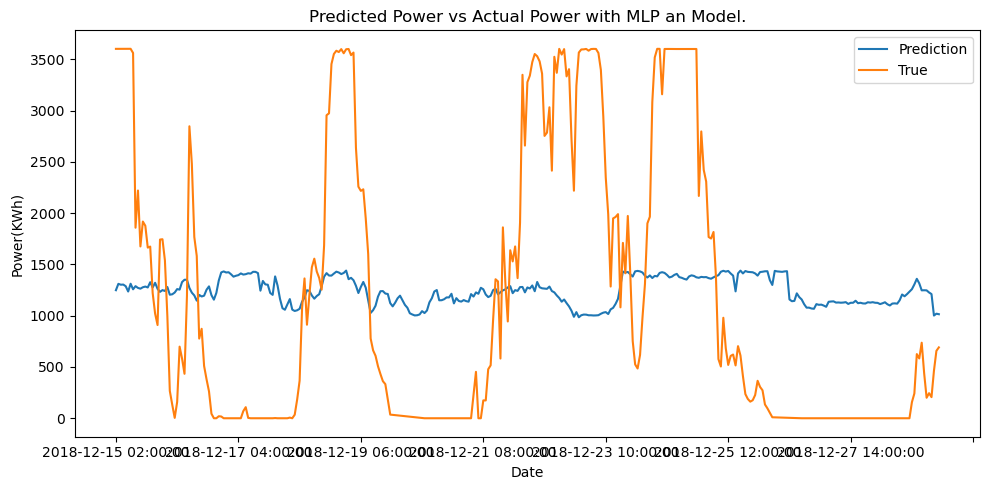

In [93]:
#plot predictions
pred_df2.plot(figsize=(10,5))
plt.title('Predicted Power vs Actual Power with MLP an Model.')
plt.ylabel('Power(KWh)')
plt.tight_layout()
plt.savefig('figures/MLP_prediction.png')
plt.show()

In [94]:
#compute metrics
rmse = np.sqrt(mean_squared_error(pred_df2['True'], pred_df2['Prediction']))
mae = mean_absolute_error(pred_df2['True'], pred_df2['Prediction'])
r2 = r2_score(pred_df2['True'], pred_df2['Prediction'])
print('RMSE: {}\nMAE: {}\nR2: {}'.format(round(rmse,2),round(mae,2), round(r2,2)))

RMSE: 1345.8
MAE: 1190.37
R2: 0.02
